# $K_{33}$-free model tests

In [9]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import time

from planar_ising import PlanarIsingModelGenerator, K5IsingModel, \
        K33freeIsingModel, K33freeInferenceAndSampling

np.random.seed(42)

matplotlib.rcParams.update({'font.size': 15})

## Model generation code

In [10]:
interaction_values_std = 0.1

In [11]:
def generate_k5_model(interaction_values_std):

    return K5IsingModel(np.random.normal(scale=interaction_values_std, size=10))

def generate_k33free_model(size, interaction_values_std):

    model = K33freeIsingModel()
    model.add_component(generate_k5_model(interaction_values_std))
    model_size = 5

    edges_counts = [10]
    edge_indices_permutations = [np.random.permutation(10)]

    while model_size != size:

        parent_index = np.random.choice(model.nodes_count)

        parent_virtual_edges_count = len(model.virtual_edge_indices[parent_index])

        if parent_virtual_edges_count == edges_counts[parent_index]:
            continue

        parent_virtual_edge_index = \
                edge_indices_permutations[parent_index][parent_virtual_edges_count]

        if model_size + 3 <= size and np.random.rand() > 0.5:

            node = generate_k5_model(interaction_values_std)
            edges_count = 10

            model_size += 3

        else:

            new_vertices_count = 1 + np.random.choice(size - model_size)

            node = PlanarIsingModelGenerator.generate_random_model(new_vertices_count + 2,
                    1.0, interaction_values_std)
            edges_count = node.graph.edges_count

            model_size += new_vertices_count
   
        node_index = model.nodes_count

        model.add_component(node)
        
        edge_indices_permutation = np.random.permutation(edges_count)
        virtual_edge_index = edge_indices_permutation[0]

        model.add_virtual_edge(parent_index, node_index, parent_virtual_edge_index,
                virtual_edge_index)

        edges_counts.append(edges_count)
        edge_indices_permutations.append(edge_indices_permutation)

    model.enumerate_model_vertices()
    
    return model

## Efficient partition function against brute-force

In [14]:
def get_log_partition_function_bruteforce(model):

    size = model.size

    partition_function = 0.0

    for configuration_index in range(1 << size):

        configuration = np.zeros(size, dtype=int)

        for spin_index in range(size):
            configuration[spin_index] = 2*((configuration_index >> spin_index) & 1) - 1

        partition_function += np.exp(model.get_minus_energy(configuration))

    return np.log(partition_function)

def simulate_and_test_partition_function_computation(interaction_values_std):

    sizes = np.arange(10, 16)

    models_per_size = 100

    maximal_relative_error = 0.0
    
    for size in sizes:
        for sample_index in range(models_per_size):

            model = generate_k33free_model(size, interaction_values_std)

            inference = K33freeInferenceAndSampling(model)

            log_partition_function = inference.compute_log_partition_function()
            bruteforce_log_partition_function = get_log_partition_function_bruteforce(model)

            relative_error = np.absolute((log_partition_function - \
                    bruteforce_log_partition_function)/bruteforce_log_partition_function)

            if relative_error > maximal_relative_error:
                maximal_relative_error = relative_error

    print('{0} random models of sizes {1} were evaluated.'.format(
            models_per_size*len(sizes), tuple(sizes)))
    print('Maximal relative error is {}.'.format(maximal_relative_error))

In [15]:
simulate_and_test_partition_function_computation(interaction_values_std)

600 random models of sizes (10, 11, 12, 13, 14, 15) were evaluated.
Maximal relative error is 1.342413415165041e-15.


## KL-divergence

We compute KL-divergence between empirical distribution produced by sample and theoretical distribution. Then we assess convergence of KL-divergence with increasing sample size. 

In [6]:
def collect_kl_statistics(interaction_values_std, model_sizes, models_per_size,
        sample_log2_sizes):

    kl_divergences = []

    for size in model_sizes:

        kl_divergences.append([])
        
        for model_index in range(models_per_size):

            kl_divergences[-1].append([])
            
            model = generate_k33free_model(size, interaction_values_std)
            inference_and_sampling = K33freeInferenceAndSampling(model)

            log_partition_function = inference_and_sampling.compute_log_partition_function()

            previous_sample_size = 0

            configuration_counts = {}
            
            for sample_size in 2**sample_log2_sizes:

                configurations = \
                        inference_and_sampling.sample_spin_configurations(sample_size - \
                        previous_sample_size)

                for configuration in configurations:

                    configuration = tuple(configuration)

                    if configuration not in configuration_counts:
                        configuration_counts[configuration] = 0

                    configuration_counts[configuration] += 1

                kl_divergence = 0.0

                for configuration, count in configuration_counts.items():

                    true_logprob = model.get_minus_energy(np.array(configuration)) - \
                            log_partition_function

                    empirical_prob = count/sample_size

                    kl_divergence += empirical_prob*(np.log(empirical_prob) - true_logprob)

                kl_divergences[-1][-1].append(kl_divergence)

                previous_sample_size = sample_size

    return np.array(kl_divergences)

def draw_kl_statistics(model_sizes, sample_log2_sizes, kl_statistics):

    plt.figure(figsize=(8, 5), dpi=100)

    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    for size_kl_statistics, size, color in zip(kl_statistics, model_sizes, colors):

        on_first_plot = True

        for model_kl_statistics in size_kl_statistics:

            plot_kwargs = {
                'zorder': 0
            }

            if on_first_plot:
                plot_kwargs['label'] = 'N={}'.format(size)
            
            plt.plot(sample_log2_sizes, model_kl_statistics, color + '--',
                    **plot_kwargs)
            plt.scatter(sample_log2_sizes, model_kl_statistics, color='k', s=10,
                    zorder=1)

            on_first_plot = False

    plt.xlabel('$\log_2 m$')
    plt.ylabel('KL-divergence')
    plt.legend()

    plt.show()

In [7]:
model_sizes = np.array([10, 15, 20])
models_per_size = 5
sample_log2_sizes = np.arange(1, 12)

kl_statistics = collect_kl_statistics(interaction_values_std, model_sizes,
        models_per_size, sample_log2_sizes)

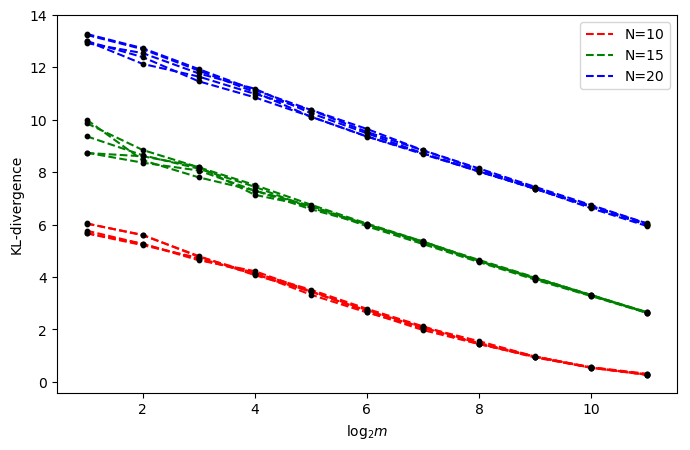

In [8]:
draw_kl_statistics(model_sizes, sample_log2_sizes, kl_statistics)

## Theoretical complexity vs. empirical

In [10]:
def measure_execution_times(interaction_values_std, model_log2_sizes, models_per_size):

    execution_times = []

    for size in 2**model_log2_sizes:

        execution_times.append([])

        for model_index in range(models_per_size):

            model = generate_k33free_model(size, interaction_values_std)

            inference_and_sampling = K33freeInferenceAndSampling(model)

            start = time.time()
            inference_and_sampling.compute_log_partition_function()
            inference_time = time.time() - start

            start = time.time()
            inference_and_sampling.prepare_for_sampling()
            inference_and_sampling.sample_spin_configurations(1)
            sampling_time = time.time() - start

            execution_times[-1].append([inference_time, sampling_time])

    return np.array(execution_times)

def draw_execution_times(model_log2_sizes, models_per_size, execution_times):

    plt.figure(figsize=(8, 5), dpi=100)

    inference_times = execution_times[:, :, 0].ravel()
    sampling_times = execution_times[:, :, 1].ravel()

    model_log2_sizes_per_point = np.repeat(model_log2_sizes, models_per_size)

    plt.scatter(model_log2_sizes_per_point, np.log2(inference_times), color='r', s=10,
            label='inference')
    plt.scatter(model_log2_sizes_per_point, np.log2(sampling_times), color='b', s=10,
            label='sampling')

    theoretical_complexity_points = 3*model_log2_sizes/2 - 10

    plt.plot(model_log2_sizes, theoretical_complexity_points, 'k--',
            label='$C * N^{1.5}$')
    
    plt.xlabel('$\log_2 N$')
    plt.ylabel('$\log_2$(sec.)')
    plt.legend()

    plt.show()

In [11]:
model_log2_sizes = np.arange(3, 11)
models_per_size = 5

execution_times = measure_execution_times(interaction_values_std, model_log2_sizes,
        models_per_size)

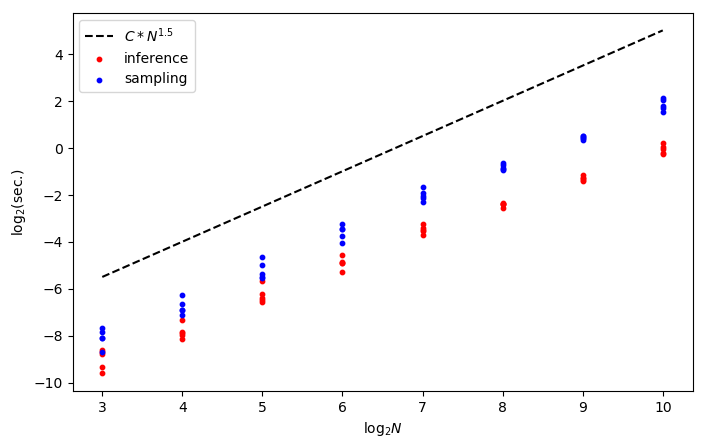

In [12]:
draw_execution_times(model_log2_sizes, models_per_size, execution_times)